In [216]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.neighbors import NearestNeighbors, KDTree
%matplotlib inline

## Generate Coordinates

In [204]:
# Generate sampling locations
def generate_coordinates(diam, num_radii, density_factor):
    """Returns two paired arrays containing cartesian coordinates (X, Y) of a polar sampling map.
    
    Args:
        diam (float): outer diameter of the polar map
        num_radii (int): number of sampling radii, including center and outer edge
        density_factor (int): factor determining angular density of points on each radius
                              R0(center): 1 point
                              R1(1st radius): density_factor * 1
                              R2(2nd radius): density_factor * 2
                              ...
                              Rn(nth radius): density_factor * n
    
    Returns:
        X (ndarray): 1D array of x coordinates
        Y (ndarray): 1D array of y coordinates
    """
    X = np.array([0.])  # initialize X coordinates with center point
    Y = np.array([0.])  # initialize Y coordinates with center point
    R = np.array([0.])
    Theta = np.array([0.])

    # loop through radii and append to X, Y coordinates
    for n, radius in enumerate(np.linspace(0, diam / 2, num_radii)):
        if n == 0:
            continue   # skip center point that has already been added at initialization
        
        num_points = point_density * n  # number of sampling points on this radius
        angles = np.radians(np.linspace(0, 360 * (1 - 1 / num_points), num_points))  # ensure not to count 0/360deg twice
        X = np.append(X, np.round(radius * np.cos(angles), 2))
        Y = np.append(Y, np.round(radius * np.sin(angles), 2))
        R = np.append(Radius, np.repeat(radius, num_points))
        Theta = np.append(Angle, np.round(np.degrees(angles), 2))
                            
    return X, Y, R, Theta

Map contains 625 points


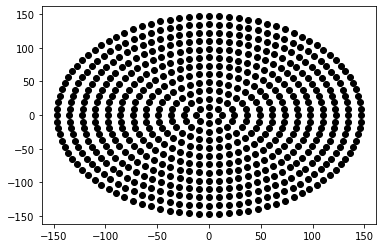

In [205]:
# Test generate_coordinates(). Map with 13 radii and density_factor=8 should have 625 points
X, Y, R, Theta = generate_coordinates(diam=294, num_radii=13, density_factor=8)
print('Map contains {} points'.format(len(X)))
plt.plot(X, Y, 'o', color='black')

## Generate data table

In [206]:
X49, Y49, R49, Theta49 = generate_coordinates(294, 4, 8)  # 49-point map
X625, Y625, R625, Theta625 = generate_coordinates(294, 13, 8)  # 625-point map

data = pd.DataFrame({'X': X625, 'Y': Y625, 'R': Radius625, 'Theta': Angle625})
data['49point Map'] = data.X.isin(X49) & data.Y.isin(Y49)  # label points belonging to both 625- and 49-point maps
# verify 49point Map labels are correct
data['49point Map'].value_counts()

False    572
True      53
Name: 49point Map, dtype: int64

## Generate Film Thickness Data

In [207]:
radial_dependence_amplitude =  10 / substrate_diameter
random_noise_amplitude = 1

data['Random_Noise'] = np.random.rand(X.shape[0]) * random_noise_amplitude
data['Radial_Dependence'] = data.R * radial_dependence_amplitude
data['Thickness_1'] = data.Random_Noise + data.Radial_Dependence
data.head(5)

,X,Y,R,Theta,49point Map,Random_Noise,Radial_Dependence,Thickness_1
0,0.00,0.00,0.00,0.0,True,0.945542,0.000000,0.945542
1,12.25,0.00,12.25,0.0,False,0.608998,0.416667,1.025665
2,8.66,8.66,12.25,45.0,False,0.408847,0.416667,0.825514
3,0.00,12.25,12.25,90.0,False,0.227721,0.416667,0.644388
4,-8.66,8.66,12.25,135.0,False,0.417244,0.416667,0.833911


Text(0.5, 1.0, 'Radial Dependence with Random Noise')

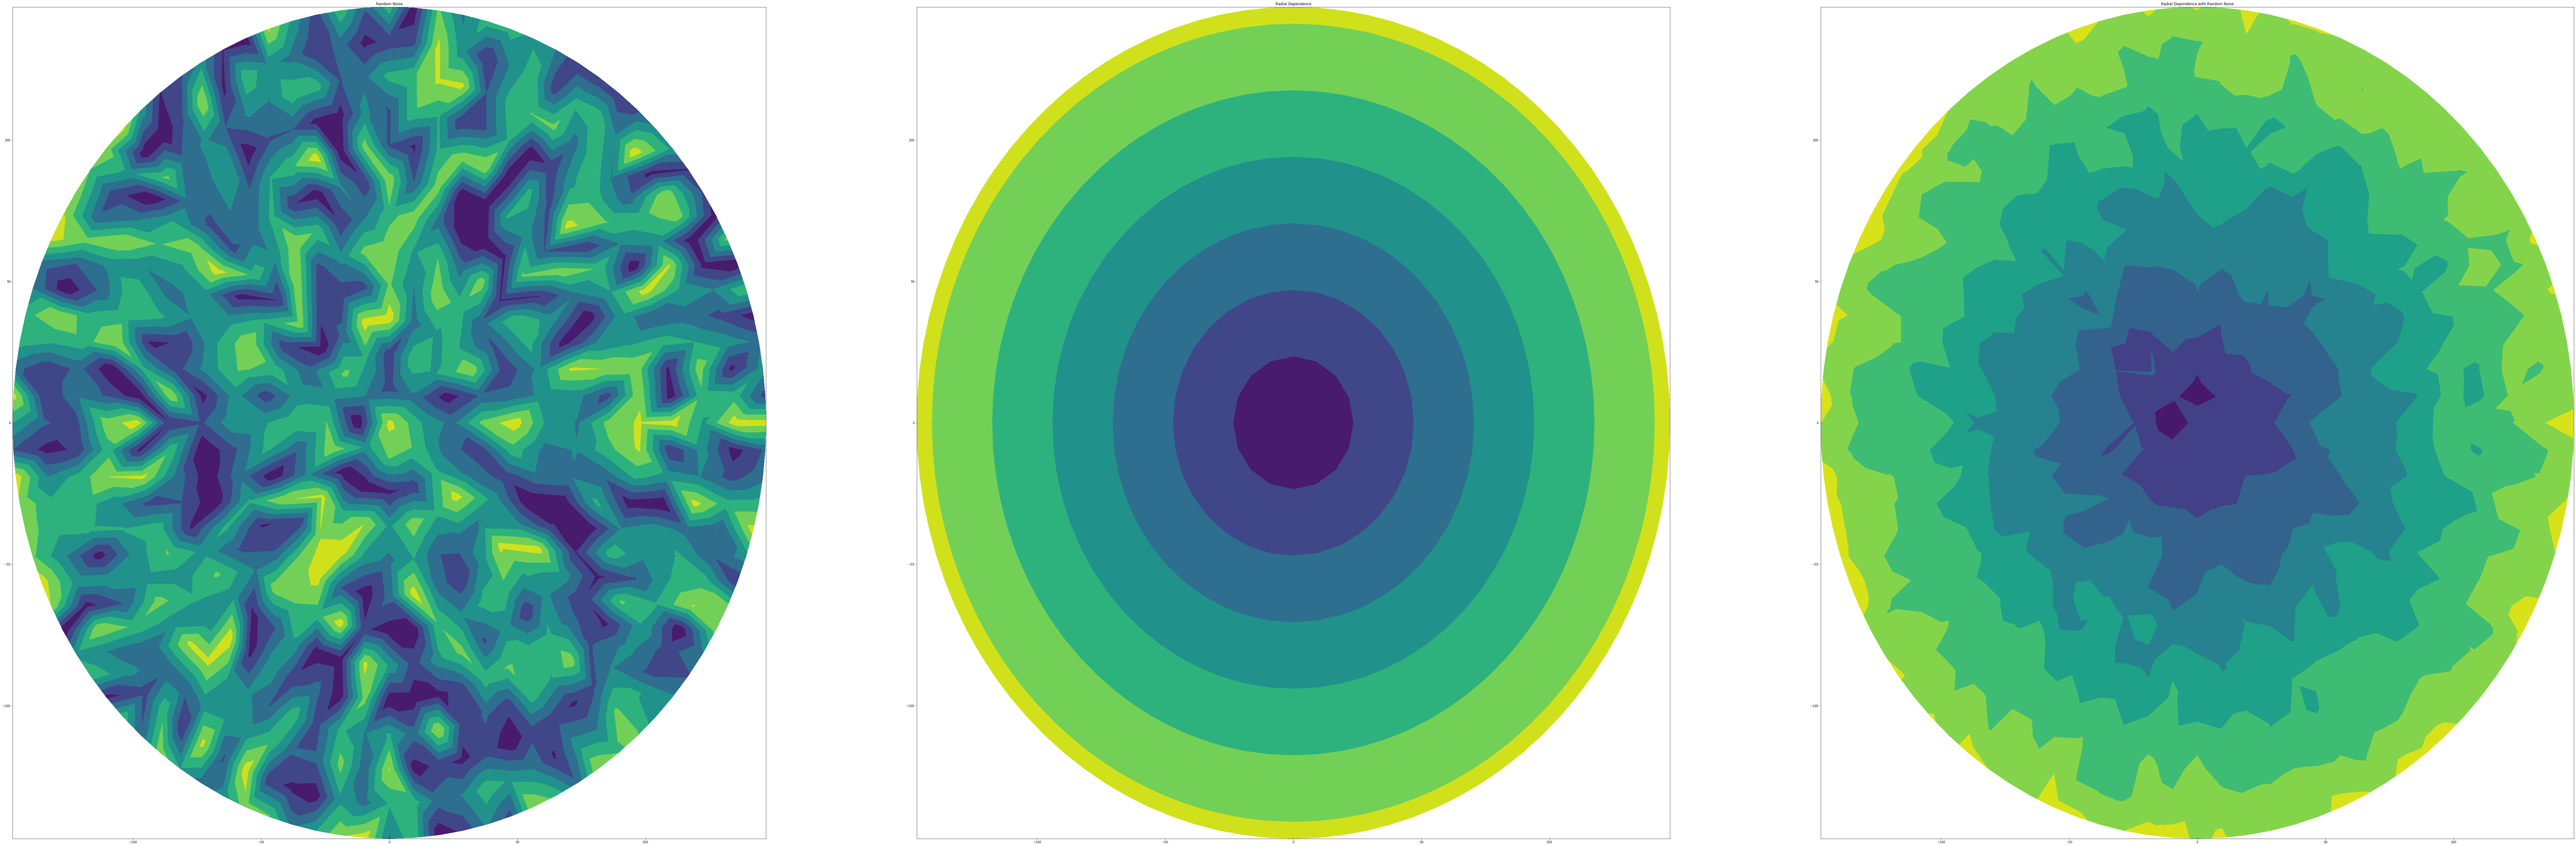

In [208]:
cmap = cm.get_cmap(name='Spectral_r')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(150, 50))
ax1.tricontourf(data.X, data.Y, data.Random_Noise)
ax1.set_title("Random Noise")
ax2.tricontourf(data.X, data.Y, data.Radial_Dependence)
ax2.set_title("Radial Dependence")
ax3.tricontourf(data.X, data.Y, data.Random_Noise + data.Radial_Dependence)
ax3.set_title("Radial Dependence with Random Noise")

## Generate Local Features

[  0.    12.25  24.5   36.75  49.    61.25  73.5   85.75  98.   110.25
 122.5  134.75 147.  ]


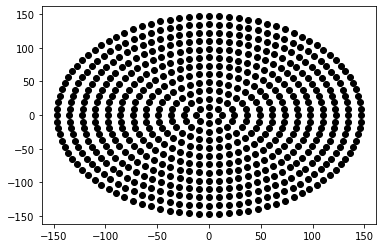

In [209]:
plt.plot(X625, Y625, 'o', color='black')
print(data.R.unique())

In [210]:
#  Generate smile
def smile_map(row):
    if 200 <= row['Theta'] <=340 and row['R'] == 73.5:
        return 0.5
    else:
        return 0
data['Smile'] = data.apply(lambda row: smile_map(row), axis=1)

# Generate eyes
def eyes_map(row):
    if 63.25 <= row['R'] <= 73.5 and ((130 <= row['Theta'] <= 140) or (40 <= row['Theta'] <= 50)):
        return 0.5
    else:
        return 0
data['Eyes'] = data.apply(lambda row: eyes_map(row), axis=1)

# Generate Face
def face_map(row):
    if ((61.25 <= row['R'] <= 73.5) and ((130 <= row['Theta'] <= 140) or (40 <= row['Theta'] <= 50)))\
        or (200 <= row['Theta'] <=340 and row['R'] == 73.5)\
        or (abs(row['X']) < 2 and -12.25 <= row['Y'] <= 24.5):
        return 0.5
    else:
        return 0
data['Face'] = data.apply(lambda row: face_map(row), axis=1)

In [211]:
data.head(5)

,X,Y,R,Theta,49point Map,Random_Noise,Radial_Dependence,Thickness_1,Smile,Eyes,Face
0,0.00,0.00,0.00,0.0,True,0.945542,0.000000,0.945542,0.0,0.0,0.5
1,12.25,0.00,12.25,0.0,False,0.608998,0.416667,1.025665,0.0,0.0,0.0
2,8.66,8.66,12.25,45.0,False,0.408847,0.416667,0.825514,0.0,0.0,0.0
3,0.00,12.25,12.25,90.0,False,0.227721,0.416667,0.644388,0.0,0.0,0.5
4,-8.66,8.66,12.25,135.0,False,0.417244,0.416667,0.833911,0.0,0.0,0.0


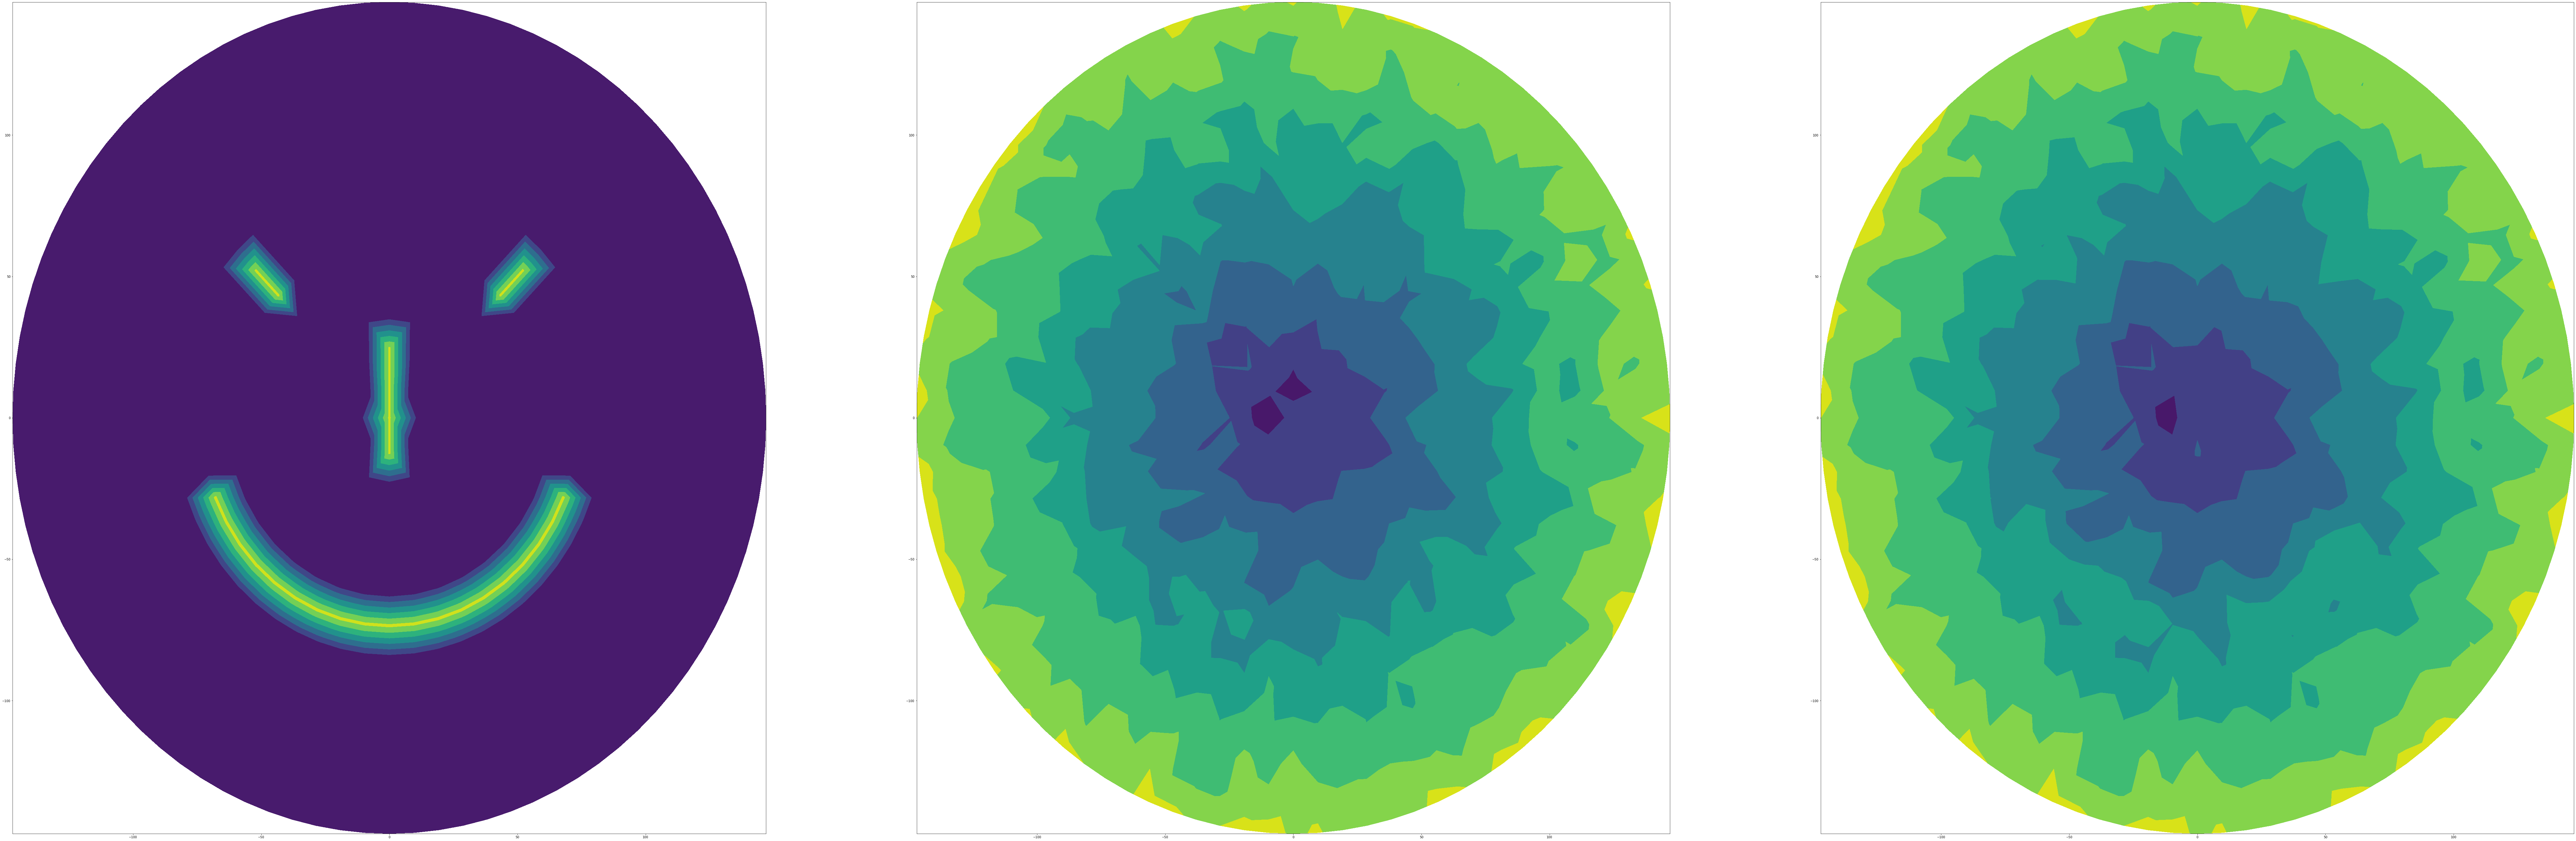

In [212]:
fig2, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(150, 50))
ax4.tricontourf(data.X, data.Y, data.Face)
ax5.tricontourf(data.X, data.Y, data.Radial_Dependence + data.Random_Noise)
ax6.tricontourf(data.X, data.Y, data.Face + data.Radial_Dependence + data.Random_Noise)

## Search for Local Features

In [290]:
# Find nearest neighbors for each point
coordinates = np.array([[x, y] for x, y in zip(data.X, data.Y)])
knn = NearestNeighbors(n_neighbors=9)
knn.fit(coordinates)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                 radius=1.0)

In [ ]:
for i in range(len(coordinates)):
    neighbors = coordinates[knn.kneighbors(coordinates[i].reshape(1, -1), return_distance=False)[0]]
    

In [291]:
neighbors = coordinates[knn.kneighbors(coordinates[0].reshape(1, -1), return_distance=False)[0]]

In [289]:
def nn_mask(row):
    for nhbr in neighbors:
        if row['X'] == nhbr[0] and row['Y'] == nhbr[1]:
            return 1
    return 0

,X,Y,R,Theta,49point Map,Random_Noise,Radial_Dependence,Thickness_1,Smile,Eyes,Face,Test,Test nn center,Coord
0,0.00,0.00,0.00,0.00,True,0.945542,0.000000,0.945542,0.0,0.0,0.5,1,None,0.00
1,12.25,0.00,12.25,0.00,False,0.608998,0.416667,1.025665,0.0,0.0,0.0,1,None,12.25
2,8.66,8.66,12.25,45.00,False,0.408847,0.416667,0.825514,0.0,0.0,0.0,1,None,8.66
3,0.00,12.25,12.25,90.00,False,0.227721,0.416667,0.644388,0.0,0.0,0.5,1,None,0.00
4,-8.66,8.66,12.25,135.00,False,0.417244,0.416667,0.833911,0.0,0.0,0.0,1,None,-8.66
5,-12.25,0.00,12.25,180.00,False,0.011063,0.416667,0.427729,0.0,0.0,0.0,1,None,-12.25
6,-8.66,-8.66,12.25,225.00,False,0.549246,0.416667,0.965913,0.0,0.0,0.0,1,None,-8.66
7,-0.00,-12.25,12.25,270.00,False,0.766207,0.416667,1.182874,0.0,0.0,0.5,1,None,-0.00
8,8.66,-8.66,12.25,315.00,False,0.751469,0.416667,1.168135,0.0,0.0,0.0,1,None,8.66
9,24.50,0.00,24.50,0.00,False,0.393947,0.833333,1.227280,0.0,0.0,0.0,0,None,24.50


In [241]:
# test knn
data['Test'] = 10 if [data.X, data.Y] in coordinates[neighbors[0]] else 0

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
